In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import karateclub
from sklearn.manifold import TSNE
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [4]:
genetox_outcomes = pd.read_csv(raw_dir/'genetox_outcomes.csv',index_col=0)
genetox_outcomes

,DTXSID,outcome,SMILES
0,DTXSID00148597,1,ClCC1=C2C=CC3=CC=CC4=C3C2=C(C=C1)C=C4
1,DTXSID00157169,1,CCNC1=C(O)C(Cl)=CC(=C1)[N+]([O-])=O
2,DTXSID00159204,0,CCO[Si](C)(CCCCl)OCC
3,DTXSID00160734,0,NCCCC(O)(P(O)(O)=O)P(O)(O)=O
4,DTXSID00162834,0,CNCC1=CC=CC2=CC=CC=C12
...,...,...,...
5398,DTXSID90890477,0,COC1=C(NC2=NC(SCCCS(O)(=O)=O)=NC(SCCCS(O)(=O)=...
5399,DTXSID90890619,0,OC(=O)C1=C(C=CC=C1)N=NC1=C2C=CC=CC2=CC=C1O
5400,DTXSID90890811,0,CCCCCCCCCC1=CC2=CC=CC=C2C(=C1CCCCCCCCC)S(O)(=O)=O
5401,DTXSID90891080,0,CC1=C(Cl)C=C(N=NC2=C(O)C=CC3=CC=CC=C23)C(=C1)S...


In [5]:

smile_outcome_dict = dict(zip(list(genetox_outcomes.SMILES),list(genetox_outcomes.outcome)))

In [30]:
gentox_dict = {k:v for k,v in zip(genetox_outcomes['DTXSID'], genetox_outcomes['outcome'])}

In [6]:
fps = []
for smile in list(smile_outcome_dict.keys()):
    mol = Chem.MolFromSmiles(smile)
    fps.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol,3,2048)))

X_fps = np.array(fps)
y = list(smile_outcome_dict.values())

knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,X_fps,y,cv=5,scoring=make_scorer(roc_auc_score))

In [7]:
print(cv['test_score'].mean())

0.6650191738817537


In [8]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,X_fps,y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.7315262876338282


In [9]:
def smile_to_mol_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    g = nx.Graph()
    
    # Add nodes with atom properties
    for atom in mol.GetAtoms():
        node_label = {
    "symbol": atom.GetSymbol(),
    "degree": atom.GetDegree(),
    "hybridization": str(atom.GetHybridization()),
    "aromaticity": atom.GetIsAromatic(),
    "formal_charge": atom.GetFormalCharge(),
    "implicit_hydrogen_count": atom.GetTotalNumHs()
}
        g.add_node(atom.GetIdx(), atom_label = str(node_label))

    # Add edges with bond properties
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=str(bond.GetBondType()))

    return g

In [10]:
graphs = {k:smile_to_mol_graph(v) for k,v in zip(genetox_outcomes['DTXSID'], genetox_outcomes['SMILES'])}

In [26]:
mydict =  {k:v for k,v in zip(genetox_outcomes['DTXSID'], genetox_outcomes['SMILES'])}

In [12]:
model_dict = {'ldp': karateclub.LDP(), 'gl2': karateclub.GL2Vec(), 'graph2vec':karateclub.Graph2Vec(attributed=True)}



In [17]:
def mol_embed(model, graphs):
    # Ensure all graphs are attributed properly
    for graph in graphs:
        for node in graph.nodes():
            if "feature" not in graph.nodes[node]:
                graph.nodes[node]["feature"] = "default"

    # Ensure all graphs have integer labels
    graphs = [nx.convert_node_labels_to_integers(g) for g in graphs]
    
    # Remove empty graphs
    graphs = [g for g in graphs if len(g.nodes) > 0]

    # Fit the model
    model.fit(graphs)
    X_embedding = model.get_embedding()

    # Perform t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    z = tsne.fit_transform(X_embedding)
    return z, X_embedding


In [19]:
results = {}
for k,v  in model_dict.items():
    results[k] = mol_embed(v, list(graphs.values()))

In [21]:
from sklearn.preprocessing import minmax_scale,StandardScaler
from scipy.spatial.distance import pdist,squareform

In [29]:
results['ldp'][0].shape

(5403, 2)

In [41]:
pd.DataFrame(list(gentox_dict.items()), columns = ['dtxsid', 'outcome']).set_index('dtxsid')

,outcome
dtxsid,
DTXSID00148597,1
DTXSID00157169,1
DTXSID00159204,0
DTXSID00160734,0
DTXSID00162834,0
...,...
DTXSID90890477,0
DTXSID90890619,0
DTXSID90890811,0


In [42]:
mydfs = []
for k, v in results.items():
    df = pd.DataFrame(v[0], columns = ['comp_1', 'comp_2'],index =mydict.keys() )
    df['approach'] = k
    df2 = pd.DataFrame(list(gentox_dict.items()), columns = ['dtxsid', 'outcome']).set_index('dtxsid')
    df = pd.concat([df,df2], axis =1)
    mydfs.append(df)

In [45]:
mydfs[2]

,comp_1,comp_2,approach,outcome
DTXSID00148597,-15.242195,6.548845,graph2vec,1
DTXSID00157169,-19.700319,-8.322796,graph2vec,1
DTXSID00159204,26.700977,3.509803,graph2vec,0
DTXSID00160734,77.558884,-5.322544,graph2vec,0
DTXSID00162834,-32.406898,-3.538014,graph2vec,0
...,...,...,...,...
DTXSID90890477,33.049133,0.409449,graph2vec,0
DTXSID90890619,-35.266361,-11.671329,graph2vec,0
DTXSID90890811,16.732437,8.477821,graph2vec,0
DTXSID90891080,20.331863,-0.099549,graph2vec,0


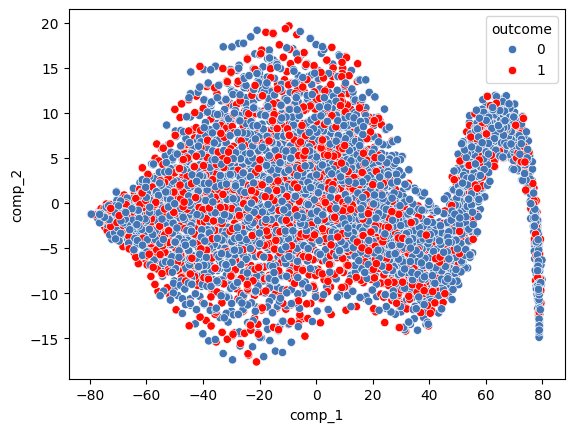

In [48]:
#df['genetox_outcome'] = df['genetox_outcome'].astype(str)
colors = ["#4374B3","#FF0B04",]
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x='comp_1',y='comp_2', hue='outcome', data=mydfs[2])
plt.savefig(figures_dir/'Graph2Vec_171224.png', dpi = 300)


In [56]:
results['graph2vec'][1]

array([[ 0.02481114, -0.01283684, -0.04589858, ..., -0.00745224,
        -0.00327372,  0.05155144],
       [ 0.02050052, -0.01290031, -0.05536439, ..., -0.01549481,
        -0.00234451,  0.04584397],
       [ 0.02828356, -0.02582851, -0.07045075, ..., -0.01934304,
        -0.01564036,  0.06331519],
       ...,
       [ 0.01399002, -0.02374086, -0.05332454, ..., -0.01156966,
        -0.01026248,  0.05358527],
       [ 0.02146791, -0.02069721, -0.05590688, ..., -0.02039467,
        -0.00297394,  0.05494505],
       [ 0.01697219, -0.0204169 , -0.04727766, ..., -0.0186489 ,
        -0.0086959 ,  0.0495473 ]], dtype=float32)

In [57]:
y = genetox_outcomes.outcome

In [58]:
knn = KNeighborsClassifier(n_jobs=-1)
cv = cross_validate(knn,results['graph2vec'][1],y,cv=5,scoring=make_scorer(roc_auc_score))
print(cv['test_score'].mean())

0.508251017661365


In [59]:
lr = LogisticRegression(n_jobs=-1)
cv = cross_validate(lr,results['graph2vec'][1],y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
print(cv['test_score'].mean())

0.5518283651734971


In [21]:
for k, v in results.items():
    for model in [knn, lr]:
        if model == knn:
            cv = cross_validate(model,v,y,cv=5,scoring=make_scorer(roc_auc_score))
            a = cv['test_score'].mean()
        else:
            cv = cross_validate(model,v,y,cv=5,scoring=make_scorer(roc_auc_score,response_method='predict_proba'))
            a = cv['test_score'].mean()
        print(k, a, model)

<karateclub.graph_embedding.ldp.LDP object at 0x75a14f823b50> 0.5962391941246116 KNeighborsClassifier(n_jobs=-1)
<karateclub.graph_embedding.ldp.LDP object at 0x75a14f823b50> 0.5485704416473681 LogisticRegression(n_jobs=-1)
<karateclub.graph_embedding.gl2vec.GL2Vec object at 0x75a14f823b20> 0.604335066616321 KNeighborsClassifier(n_jobs=-1)
<karateclub.graph_embedding.gl2vec.GL2Vec object at 0x75a14f823b20> 0.5986226009860853 LogisticRegression(n_jobs=-1)
<karateclub.graph_embedding.graph2vec.Graph2Vec object at 0x75a14f8235e0> 0.5263896054492455 KNeighborsClassifier(n_jobs=-1)
<karateclub.graph_embedding.graph2vec.Graph2Vec object at 0x75a14f8235e0> 0.5003833007010743 LogisticRegression(n_jobs=-1)
